# Local linear network

In [1]:
import numpy as np
import sklearn
from nmf_with_missing_values import nmf_with_missing_values
import ipyvolume
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
%matplotlib inline

## load the data

In [19]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz')
data = tmp['data']
sections = tmp['sections']
original_shape = data.shape
d = data.shape[1] * data.shape[2] * data.shape[3]
data = np.reshape(data, (data.shape[0], d))

In [53]:
aaa = sections.item()

## calculate nmf (could be quite long, do not run this chunk if you have the intermediate result

In [3]:
nmf = nmf_with_missing_values(n_outer_loops = 4, n_components = 14)
D = nmf.fit_transform(data)
A = nmf.components_

KeyboardInterrupt: 

## save the intermediate result

In [5]:
np.savez('tmp_result.npz', D = D, A = A, X_guess = nmf.X_guess, data = data, original_shape = original_shape)

## load the intermediate result 

In [14]:
f = np.load('tmp_result.npz')
A = f['A']
original_shape = f['original_shape']
X_guess = f['X_guess']
coefs = f['D']

### reshape the dictionary

In [5]:
D_cube = A.reshape([14] + list(original_shape[1:])) 

In [6]:
assert np.allclose(D_cube[0,:], A[0, :].reshape(original_shape[1:]))

### arrange the patterns based on their weighted center

In [7]:
weightings = np.sum(D_cube, (2, 3))
index = np.argsort([np.argmax(weightings[x, :]) for x in range(14)])

### look at 2D projections of each pattern

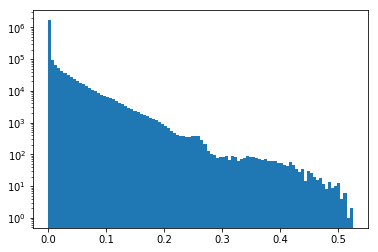

In [8]:
plt.hist(D_cube.flatten(), 100)
plt.yscale('log')
plt.show()

In [9]:
D_cube = D_cube[index, :, :, :]

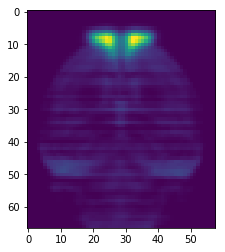

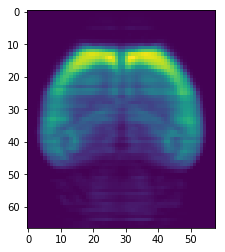

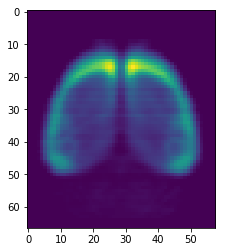

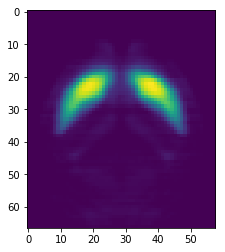

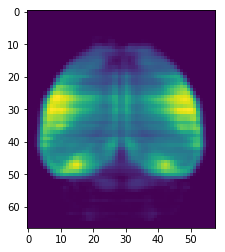

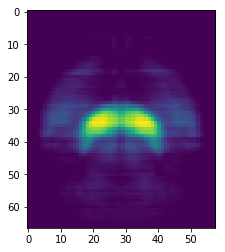

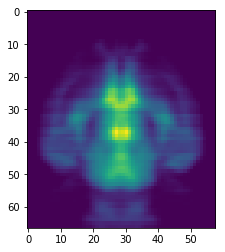

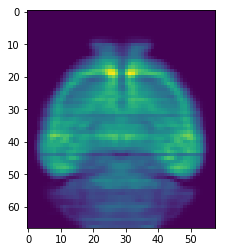

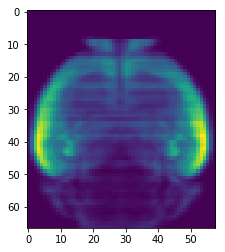

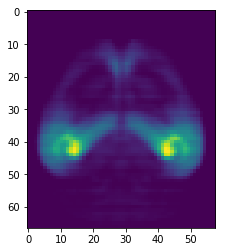

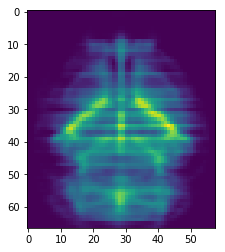

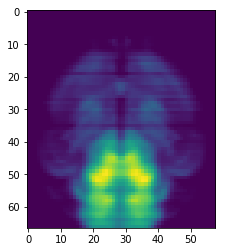

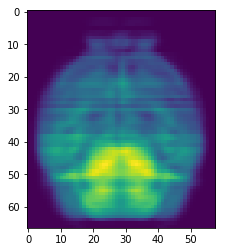

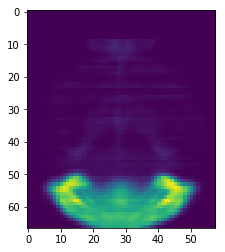

In [11]:
D_shrink = np.maximum(D_cube - 0, 0)
for i in range(14):
    plt.figure()
    plt.imshow(np.mean(D_shrink[i, :, :, :], 1))

### compute the local linear network

In [16]:
import networkx as nx

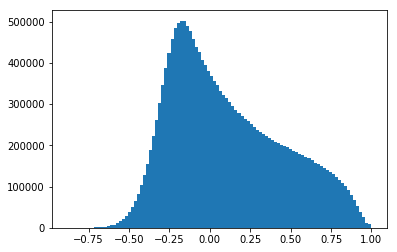

In [44]:
plt.hist((np.corrcoef(coefs).flatten()), 100)
plt.show()

In [68]:
corr_matrix = np.corrcoef(coefs)
lower_bound = np.percentile(corr_matrix.flatten(), 5)
upper_bound = np.percentile(corr_matrix.flatten(), 99)
adj_matrix = corr_matrix > upper_bound

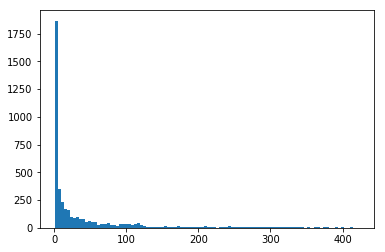

In [72]:
plt.hist(np.sum(adj_matrix, 0),100)
plt.show()

In [69]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    #print(gr.degree())
    remove = [node for node,degree in gr.degree() if degree == 1]
    gr.remove_nodes_from(remove)
    nx.draw(gr, node_size=50, labels=mylabels, with_labels=False)
    plt.show()

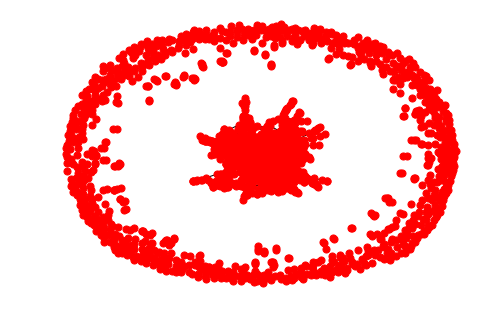

In [70]:
show_graph_with_labels(adj_matrix, aaa)